# Graphical Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from tqdm import tqdm
import networkx as nx
import scipy

In [2]:
class my_GLasso():
    
    def __init__(self, lambd=0.01, mu=0.01, max_iter = 60):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.lambd = lambd
        self.mu = mu
        self.max_iter = max_iter
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO
        n = X.shape[0]
        p = X.shape[1]
        mu = np.mean(X, axis=0)
        X_centered = X - mu
        S = np.dot(X_centered.T, X_centered) / n
        self.precision_ = np.linalg.pinv(S)
        Z = np.eye(p)
        V = np.eye(p)
        for k in tqdm(range(self.max_iter)):
            T = -V + Z - (1/self.mu)*S
            L, Q = np.linalg.eigh(T)
            L = (L + np.sqrt(L**2 + 4/self.mu))/2
            P = np.dot(np.dot(Q, np.diag(L)), Q.T)
            Z = np.sign(P + V)*np.maximum(np.abs(P + V) - self.lambd/self.mu, 0)
            V = V + self.mu*(P - Z)
            self.precision_ = P
            self.covariance_ = np.linalg.pinv(self.precision_)

100%|██████████| 100/100 [00:00<00:00, 1293.48it/s]


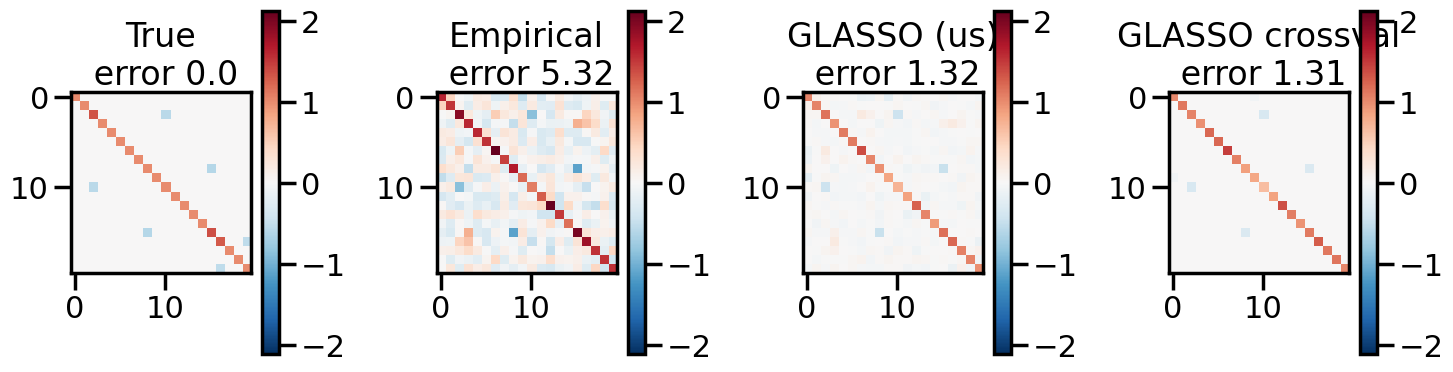

In [3]:
# TODO : Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98, smallest_coef=.4, largest_coef=.7, random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Graphical Lasso CV estimation
from sklearn.covariance import GraphicalLassoCV
glasso_cv = GraphicalLassoCV()
glasso_cv.fit(data)
prec_glassocv = glasso_cv.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Our Graphical Lasso implementation
glasso = my_GLasso(lambd=0.1, mu=0.1, max_iter=100)
glasso.fit(data)
prec_glasso = glasso.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)

# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

vmax = max(np.abs(prec).max(), np.abs(prec_empirical).max(), np.abs(prec_glasso).max(), np.abs(prec_glassocv).max())

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    im = ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, shrink=0.8)

fig.tight_layout()
plt.show()

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [4]:
from sklearn.linear_model import LassoCV
from joblib import Parallel, delayed

class my_nodewise_regression:
    
    def __init__(self, rule='AND', eps=1e-8, n_jobs=-1):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        eps: float, default=1e-8
            Threshold for coefficients to consider edges.
        n_jobs: int, default=-1
            Number of parallel jobs for LassoCV computations.
        
        Attributes:
        
        graph_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated adjacency matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.eps = eps
        self.n_jobs = n_jobs
        
    def _fit_lasso_for_feature(self, i, X, n, p):
        """Fit LassoCV for the i-th feature and return non-zero coefficients."""
        y_train = X[:, i]
        X_train = np.delete(X, i, axis=1)
        reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
        coefs = reg.coef_
        dic = {}
        for j, coef in enumerate(coefs):
            if np.abs(coef) > self.eps:
                dic[j if j < i else j + 1] = coef
        return dic
    
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------

        X: (n, p) np.array
            Data matrix
        
        Returns:
        ------
        self
        """         
        n, p = X.shape
        
        # Parallel computation of Lasso regressions
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_lasso_for_feature)(i, X, n, p) for i in range(p)
        )
        
        # Construct adjacency matrix
        self.graph_structure_ = np.zeros((p, p), dtype=int)
        for i in range(p):
            for j in range(p):
                if i != j:
                    if self.rule == 'AND':
                        if i in results[j] and j in results[i]:
                            self.graph_structure_[i, j] = 1
                    elif self.rule == 'OR':
                        if i in results[j] or j in results[i]:
                            self.graph_structure_[i, j] = 1
                    else:
                        raise ValueError('rule must be "AND" or "OR"')
        
        return self

In [5]:
np.random.seed(1)
n = 5000
p = 6
epsilon=1e-1
X = np.random.randn(n, p)
X.T[1] += X.T[0]
X.T[2] += X.T[1]
real_graph_structure = np.zeros((p, p))
real_graph_structure[0,1] = 1
real_graph_structure[1,0] = 1
real_graph_structure[1,2] = 1
real_graph_structure[2,1] = 1

In [6]:
nx_real = nx.from_numpy_array(real_graph_structure.T)
nx.draw(nx_real, with_labels=True)

#On dessine la structure initiale

We notice that the initial graph is **poorly connected**, there are a lot of conditional independances between the components.

When we will reconstruct the graph with the predicted value of the precision matrix, **we expect higher values for the conditional correlation between nodes 0, 1 and 2**. 

However, based on what we saw before, we must expect a complete graph if we dont specify a minimum weight for the edges to be taken into account.

100%|██████████| 60/60 [00:00<00:00, 6903.83it/s]


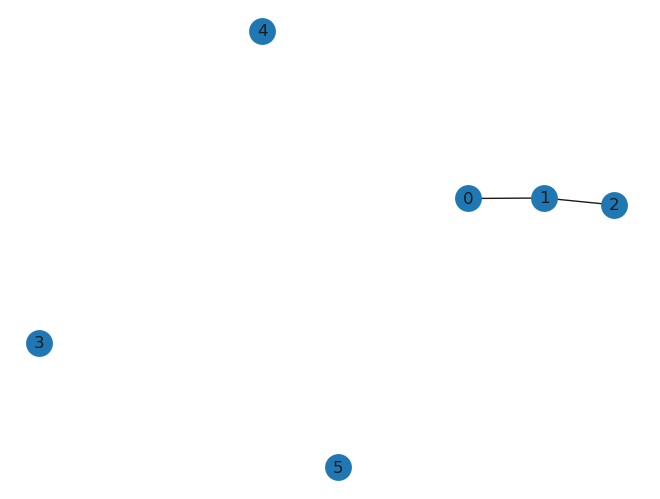

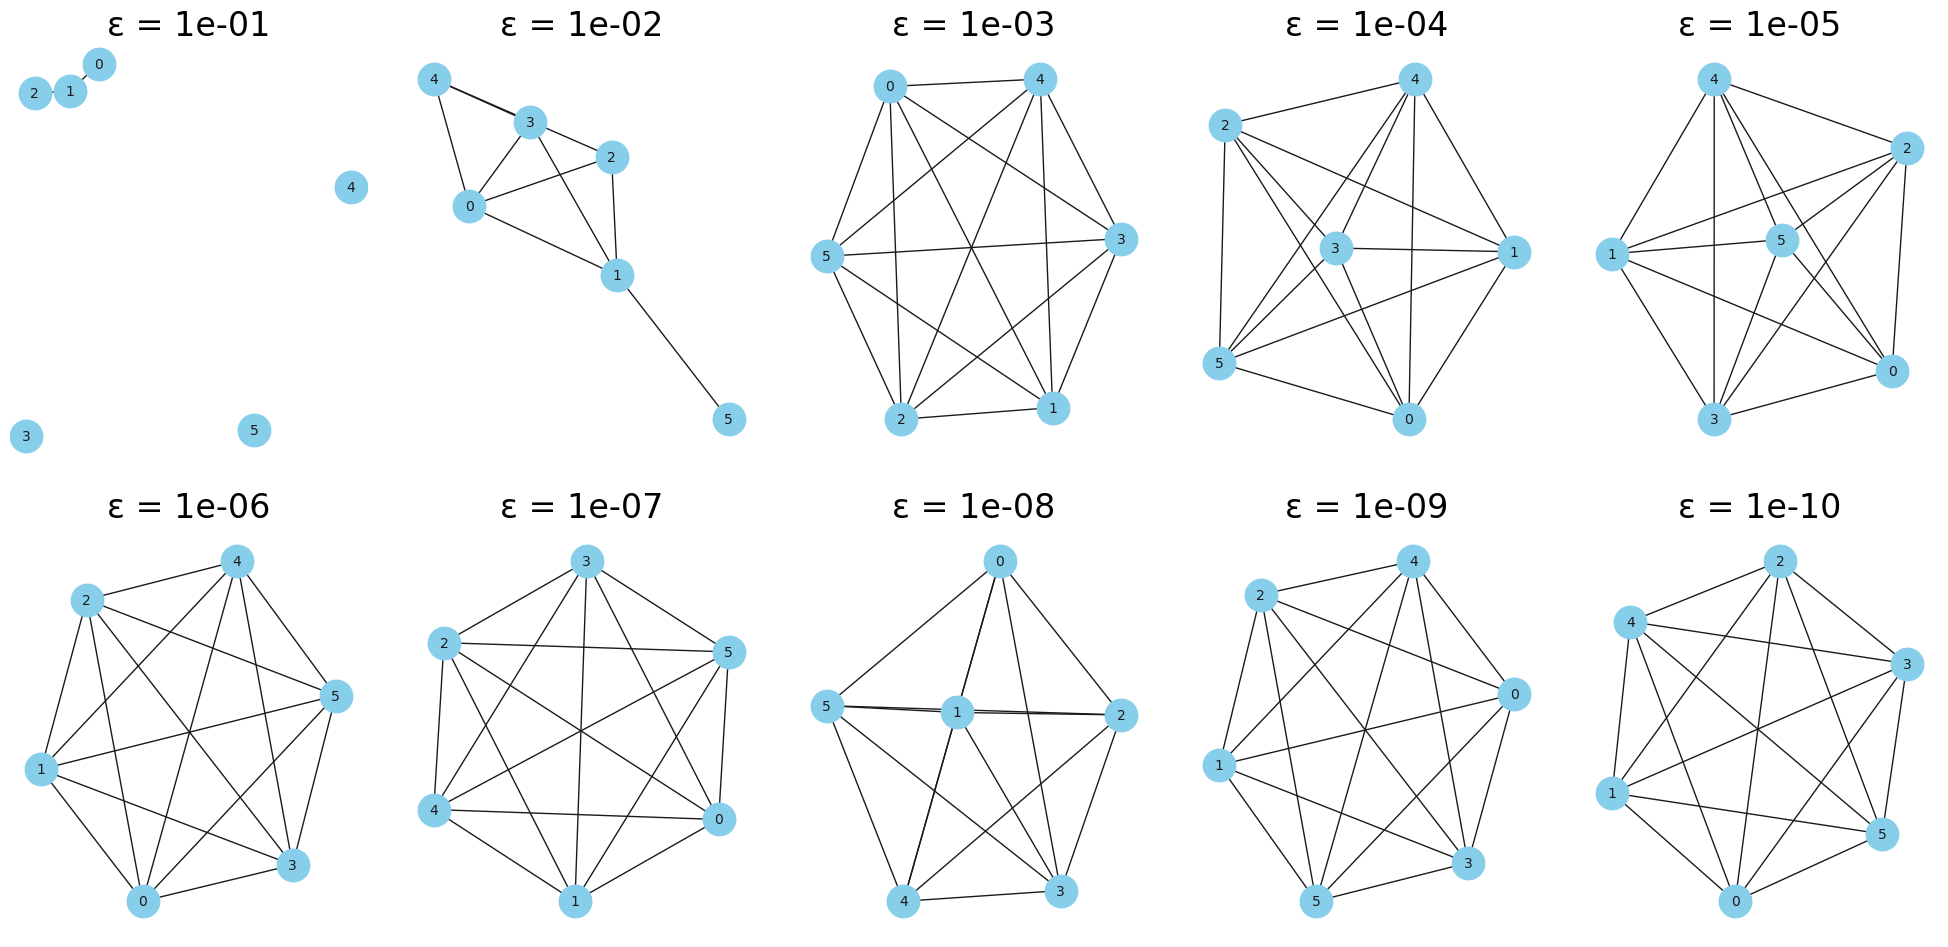

In [7]:
#TODO : plot the reconstructed graph with GLASSO using different thresholds. Comment the impact of the choice of the threshold
# Application pour différentes valeurs de epsilon
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 lignes, 5 colonnes
axes = axes.flatten()

for idx, eps in enumerate(epsilons):
    # Application de GLasso
    glasso = my_GLasso()
    glasso.fit(X)
    
    # Conversion en graphe binaire
    graph_structure = (np.abs(glasso.precision_) >= eps).astype(int)
    np.fill_diagonal(graph_structure, 0)  # Supprimer les boucles
    
    # Création et tracé du graphe
    nx_real = nx.from_numpy_array(graph_structure.T)
    ax = axes[idx]
    nx.draw(
        nx_real,
        with_labels=True,
        node_color="skyblue",
        node_size=500,
        font_size=10,
        ax=ax
    )
    ax.set_title(f'ε = {eps:.0e}')

# Ajustement des espaces
plt.tight_layout()
plt.show()

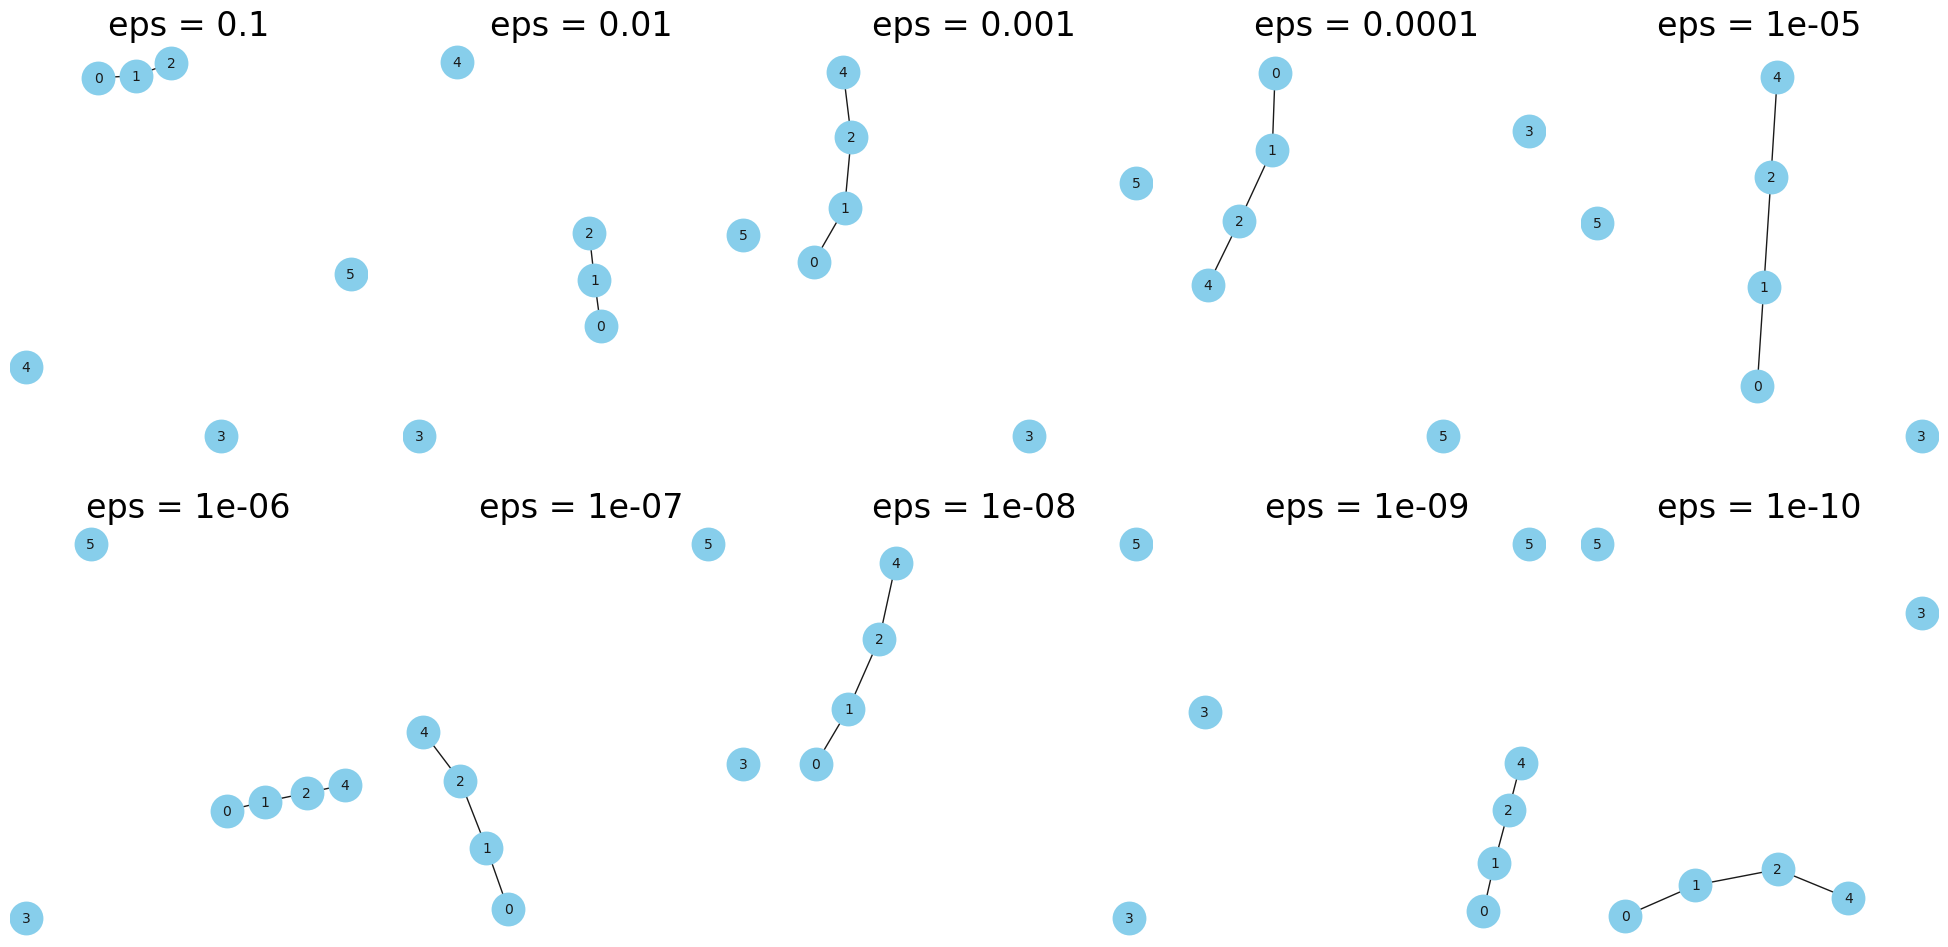

In [8]:
#TODO : plot the reconstructed graph with nodewise regression using the rule AND
# Liste des epsilon
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# Initialiser une figure avec sous-graphes
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 lignes, 5 colonnes
axes = axes.flatten()  # Aplatir la grille pour une itération facile

for i, eps in enumerate(epsilons):
    # Exécuter l'algorithme
    nodewise_regression = my_nodewise_regression(rule='AND', eps=eps)
    nodewise_regression.fit(X)
    nx_real = nx.from_numpy_array(nodewise_regression.graph_structure_.T)
    
    # Tracer sur le sous-graphe
    ax = axes[i]
    nx.draw(nx_real, with_labels=True, ax=ax, node_color="skyblue", node_size=500, font_size=10)
    ax.set_title(f'eps = {eps}')

# Supprimer les axes inutilisés (si applicable)
for j in range(len(epsilons), len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

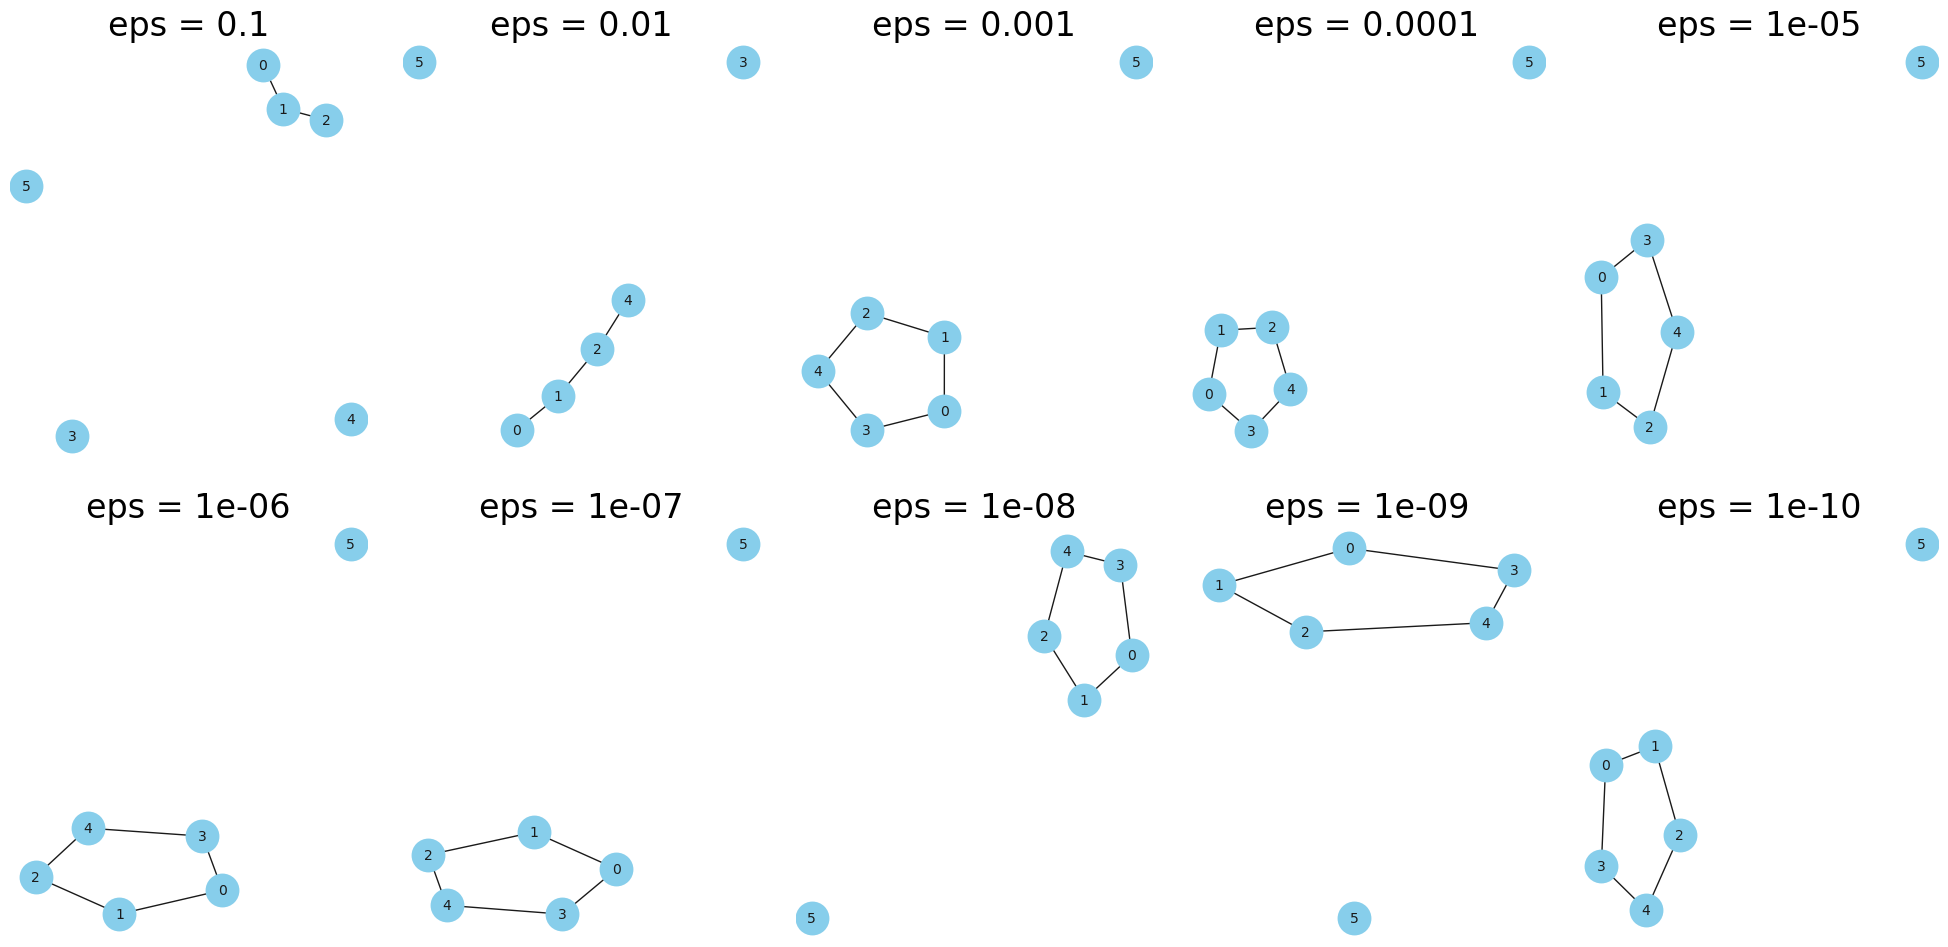

In [9]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
# Liste des epsilon
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# Initialiser une figure avec sous-graphes
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 lignes, 5 colonnes
axes = axes.flatten()  # Aplatir la grille pour une itération facile

for i, eps in enumerate(epsilons):
    # Exécuter l'algorithme
    nodewise_regression = my_nodewise_regression(rule='OR', eps=eps)
    nodewise_regression.fit(X)
    nx_real = nx.from_numpy_array(nodewise_regression.graph_structure_.T)
    
    # Tracer sur le sous-graphe
    ax = axes[i]
    nx.draw(nx_real, with_labels=True, ax=ax, node_color="skyblue", node_size=500, font_size=10)
    ax.set_title(f'eps = {eps}')

# Supprimer les axes inutilisés (si applicable)
for j in range(len(epsilons), len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [10]:
from sklearn.metrics import accuracy_score, f1_score

# Function to simulate AR(1)-Block model
def simulate_ar1_block(p, block_size, rho):
    n_blocks = p // block_size
    cov_matrix = np.zeros((p, p))
    for k in range(n_blocks):
        for i in range(block_size):
            for j in range(block_size):
                cov_matrix[k * block_size + i, k * block_size + j] = rho ** abs(i - j)
    return cov_matrix

# Function to simulate exponential decay model
def simulate_exp_decay(p, decay):
    precision_matrix = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            precision_matrix[i, j] = np.exp(-decay * abs(i - j))
    return precision_matrix

# Simulation setup
p = 300
n_samples = [40, 80, 320]
block_size = 30
rho = 0.9
decay = 2
threshold = 1e-1

# Containers for evaluation
results = {
    'n': [],
    'model': [],
    'frobenius_glasso': [],
    'accuracy_nodewise': [],
    'f1_nodewise': []
}

In [11]:
for n in tqdm(n_samples):
    print('----- Création des données et modèles pour n =', n, '-----')
    # AR(1)-Block model
    ar1_cov = simulate_ar1_block(p, block_size, rho)
    ar1_data = np.random.multivariate_normal(np.zeros(p), ar1_cov, size=n)
    ar1_true_graph = (ar1_cov > threshold).astype(int)
    
    # Exponential decay model
    exp_prec = simulate_exp_decay(p, decay)
    exp_cov = np.linalg.inv(exp_prec)
    exp_data = np.random.multivariate_normal(np.zeros(p), exp_cov, size=n)
    exp_true_graph = (np.abs(exp_prec) > threshold).astype(int)

    for model, data, true_graph in tqdm(zip(
        ['AR(1)-Block', 'Exponential Decay'], 
        [ar1_data, exp_data], 
        [ar1_true_graph, exp_true_graph]
    )):
        # GLasso estimation
        print(f'CV du GLASSO ...')
        glasso = GraphicalLassoCV(cv=5)
        glasso.fit(data)
        # Optimal lambda (alpha)
        optimal_lambda = glasso.alpha_
        print(f"Optimal lambda selected by cross-validation: {optimal_lambda}")
        frobenius_glasso = np.linalg.norm(glasso.precision_ - np.linalg.inv(np.cov(data, rowvar=False)))
        
        # Nodewise regression
        print(f'Nodewise regression ...')
        nodewise = my_nodewise_regression(eps=threshold)
        nodewise.fit(data)
        pred_graph = nodewise.graph_structure_
        accuracy_nodewise = accuracy_score(true_graph.flatten(), pred_graph.flatten())
        f1_nodewise = f1_score(true_graph.flatten(), pred_graph.flatten())

        # Store results
        results['n'].append(n)
        results['model'].append(model)
        results['frobenius_glasso'].append(frobenius_glasso)
        results['accuracy_nodewise'].append(accuracy_nodewise)
        results['f1_nodewise'].append(f1_nodewise)

  0%|          | 0/3 [00:00<?, ?it/s]

----- Création des données et modèles pour n = 40 -----


CV du GLASSO ...


c:\Users\victo\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal lambda selected by cross-validation: 0.3637752611378519
Nodewise regression ...


CV du GLASSO ...


c:\Users\victo\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal lambda selected by cross-validation: 0.5720602379585645
Nodewise regression ...


2it [02:07, 63.79s/it]
 33%|███▎      | 1/3 [02:08<04:16, 128.08s/it]

----- Création des données et modèles pour n = 80 -----


CV du GLASSO ...


c:\Users\victo\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal lambda selected by cross-validation: 0.30807117751569996
Nodewise regression ...


CV du GLASSO ...


c:\Users\victo\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal lambda selected by cross-validation: 0.501364311370879
Nodewise regression ...


2it [05:45, 172.78s/it]
 67%|██████▋   | 2/3 [07:54<04:16, 256.31s/it]

----- Création des données et modèles pour n = 320 -----


CV du GLASSO ...


c:\Users\victo\anaconda3\Lib\site-packages\sklearn\covariance\_graph_lasso.py:160: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\covariance\_graph_lasso.py:161: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
c:\Users\victo\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal lambda selected by cross-validation: 0.2526049353824327
Nodewise regression ...


CV du GLASSO ...


c:\Users\victo\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal lambda selected by cross-validation: 0.17196785805529116
Nodewise regression ...


1it [11:17, 677.56s/it]
 67%|██████▋   | 2/3 [19:11<09:35, 576.00s/it]


KeyboardInterrupt: 

In [ ]:
# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print("Graph Estimation Results")
print(results_df.to_string(index=False))

Graph Estimation Results
  n             model  frobenius_glasso  accuracy_nodewise  f1_nodewise
 40       AR(1)-Block      1.356041e+18           0.914644     0.135105
 40 Exponential Decay      9.012783e+17           0.988867     0.003976
 80       AR(1)-Block      2.268527e+17           0.914556     0.133033
 80 Exponential Decay      1.195041e+18           0.989533     0.008421
320       AR(1)-Block      1.033104e+04           0.914444     0.130926
320 Exponential Decay      1.213917e+03           0.990089     0.017621


- Le GLasso nécessite un grand nombre d'échantillons pour fournir une bonne approximation, en particulier pour des structures complexes
- La méthode Nodewise regression est globalement précise pour identifier les absences d'arêtes, même dans des cas difficiles comme l'Exponential Decay.
- Les méthodes utilisées peinent à capturer correctement les connexions spécifiques dans les deux modèles, surtout pour l'Exponential Decay. Cela peut être dû à la densité et à la nature des dépendances dans ce modèle.